In [2]:
import sys
sys.path.append('../src')

In [12]:
import data_loader, models 
import os 
import glob 
import pytest
import random
import pandas as pd 
from functools import reduce 
import numpy as np 
from numpy import sin, cos

def test_StochasticGWBackgroundModel():




    # Construct the invariant directory path
    directory = '../data/IPTA_MockDataChallenge/IPTA_Challenge1_open/Challenge_Data/Dataset2/'


    # Get all .par files in the directory
    par_files = sorted(glob.glob(directory + '*.par'))
    tim_files = sorted(glob.glob(directory + '*.tim'))

    assert len(par_files) == len(tim_files) 


    # Combine par_files and tim_files into pairs
    file_pairs = list(zip(par_files, tim_files))



    #Data loading block with some dataframe shenanigans. We should move the df stuff to src/

    dfs = []
    dfs_meta = []
    total_num_rows = 0 
    i = 0
    
    for par_file, tim_file in file_pairs[0:2]:
        psr = data_loader.LoadWidebandPulsarData.read_par_tim(par_file, tim_file)

        print(psr.M_matrix.shape)
        print(psr.fitpars)

        df = pd.DataFrame({'toas': psr.toas, f'residuals_{i}': psr.residuals})

        #df_meta = pd.DataFrame({'name': [psr.name], f'dim_M': [psr.M_matrix.shape[-1]],f'RA': [psr.RA],f'DEC': [psr.DEC]})

        #just for testing with 2 pulsars, let M1 = 2 and M2 = 3
        df_meta = pd.DataFrame({'name': [psr.name], f'dim_M': 2+i, f'RA': [psr.RA],f'DEC': [psr.DEC]})



        dfs.append(df)
        dfs_meta.append(df_meta)

        total_num_rows += len(df)
        i += 1
    


    merged_df = reduce(lambda left, right: pd.merge(left, right, on='toas', how='outer'), dfs)
    combined_df = pd.concat(dfs_meta, ignore_index=True)
    
    print(combined_df)

    ra = combined_df['RA'].to_numpy()
    dec = combined_df['DEC'].to_numpy()



    """
    Given a latitude theta and a longitude phi, get the xyz unit vector which points in that direction 
    """
    def _unit_vector(theta,phi):
        qx = sin(theta) * cos(phi)
        qy = sin(theta) * sin(phi)
        qz = cos(theta)
        return np.array([qx, qy, qz]).T
    
    q = _unit_vector(np.pi/2.0 -dec, ra) # 3 rows, N columns
    Npsr = len(combined_df)


    #Get angle between all pulsars
    #Doing this explicitly for completeness - I am sure faster ways exist
    ζ = np.zeros((Npsr,Npsr))

    for i in range(Npsr):
        for j in range(Npsr):

            if i == j: #i.e. angle between same pulsars is zero
                ζ[i,j] = 0.0 
                
            else: 
                vector_1 = q[i,:]
                vector_2 = q[j,:]
                dot_product = np.dot(vector_1, vector_2)

                ζ[i,j] = np.arccos(dot_product)

    model = models.StochasticGWBackgroundModel(combined_df)


    #     # Set global parameters.
    params = {
        'γa': 0.001,      # s^-1
        'γp': np.ones(len(combined_df)),
        'σp': 1e-10*np.ones(len(combined_df)),
        'h2': 1e-12,
        'σeps': 1,
        'separation_angle_matrix': ζ

    }


    model.set_global_parameters(params)
   
    dt = 0.50
    F = model.F_matrix(dt)
    Q = model.Q_matrix(dt)


    
    assert F.shape == (model.nx, model.nx)
    assert Q.shape == F.shape


    print(Q.shape)
    np.set_printoptions(linewidth=200)
    print(Q)

    Q[Q != 0] = 1
    import matplotlib.pyplot as plt 
    plt.imshow(Q.T, cmap='binary', interpolation='none')
    plt.show()

    # def test_F_matrix(self):
    #     """Abstract method for the model state transition matrix F."""
    #     pass






(130, 8)
['Offset', 'RAJ', 'DECJ', 'F0', 'F1', 'PMRA', 'PMDEC', 'PX']
(130, 11)
['Offset', 'RAJ', 'DECJ', 'F0', 'F1', 'PX', 'PB', 'A1', 'TASC', 'EPS1', 'EPS2']
         name  dim_M        RA       DEC
0  J0030+0451      2  0.132895  0.084841
1  J0218+4232      3  0.602600  0.742431
block sizes =  [6, 7]
cum_sizes =  [ 0  6 13]
(13, 13)
[2 3]
Iterating over pulsar  0
i0, i1 =  0 6
Iterating over pulsar  1
i0, i1 =  6 13
(13, 13)
[[2.91215988e-22 7.74090609e-22 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.74090609e-22 3.16060279e-21 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.94183593e-18 2.08229197e-17 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.14944441e-19 9.44715906e-19 0.00000000e+00 0.000

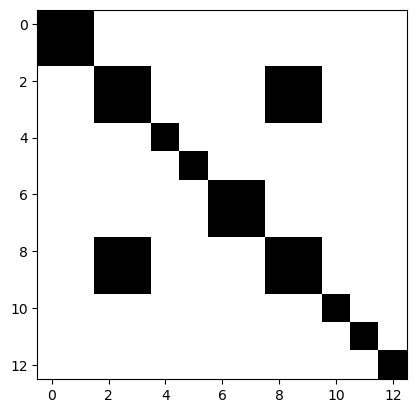

In [13]:
test_StochasticGWBackgroundModel()